# Candidate Association Study

This note demonstrates the workflow for candidate association analysis in genetics, using a subset of **212** individuals and **14** SNPs from sample data set `SNP_29C` with **212** individuals and **253,141** SNPs. `SNP_29Ctraitdata.txt` contains 2 phenotypes of the 212 individuals, column 1 identifies the individuals family ID, column 2 individual ID, and columns 3 and 4 are traits 1 and 2 respectively.

We fit a Linear Mixed Model with the kinship matrix as a random effect, and sex and genotype as fixed effects. 
We store the resulting regression coefficients and p-value estimates in .csv files, labeled by SNP name.

In [1]:
;ls "SNP_29C*.*"

SNP_29C.bed
SNP_29C.bim
SNP_29C.fam
SNP_29Ctraitdata.csv


## SNP Candidates for Association Study

In [2]:
SNP_list = 
["rs35121332",
 "rs59004768",
 "rs55799796",
 "rs3826883" ,
 "rs34804158",
 "rs10412915",
 "rs11672206",
 "rs2116886" ,
 "rs71367132",
 "rs11667481",
 "rs1036231" ,
 "rs1036232" ,
 "rs11671837",
 "rs7253480" ]

14-element Array{String,1}:
 "rs35121332"
 "rs59004768"
 "rs55799796"
 "rs3826883" 
 "rs34804158"
 "rs10412915"
 "rs11672206"
 "rs2116886" 
 "rs71367132"
 "rs11667481"
 "rs1036231" 
 "rs1036232" 
 "rs11671837"
 "rs7253480" 

## Read in binary SNP data

We run the association analysis with just the following 14 SNP'S in SNP_list. These 14 SNP's are ones that were found significant in the pedGWAS for either one trait or the joint analysis of both traits. The SNP used to simulate the association was rs10412915 so it is the "causal SNP", the others are in LD.

We will use the [`SnpArrays.jl`](https://github.com/OpenMendel/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue 
```julia
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
```
within `Julia` to install the `SnpArrays` package.

In [3]:
using SnpArrays
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time SNP_29C = SnpArray("SNP_29C")

  0.536328 seconds (221.41 k allocations: 24.498 MiB, 1.17% gc time)


212×253141 SnpArrays.SnpArray{2}:
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)      (true, true)    (false, false)
 (true, true)  (true, true)   …  (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 (true, true)  (false, true)  …  (false, false)  (true, true)  
 (true, true)  (true, true)      (false, false)  (true, true)  
 (true, true)  (false, true)     (false, false)  (true, true)  
 ⋮                            ⋱                  ⋮             
 (true, true)  (true, true)   …  (true, true)    (false, false)
 (true

## Empirical Kinship Matrix

In this example we estimate the empirical kinships based on all 253,141 SNPs by Genetic Relationship Matrix.

Both the GRM and the MoM methods are fairly quick to calculate and provide good estimates for the kinship coefficients, given reasonably dense genome-wide data. When using the GRM method, very rare SNPs should not be used since they become overweighted. In general, one can think of the GRM method centering and scaling each genotype, while the MoM method uses the raw genotypes and then centers and scales the final result. 

!!! note

    It is important to note that sometimes MoM formulation does not guarantee Positive Semi-Definiteness. Thus, for the rest of this example we will use the GRM formulation of the empirical Kinship coefficients. 

### Kinship via Genetic Relationship Matrix (GRM)

Under the GRM formulation, the estimate of the global kinship coefficient of individuals $i$ and $j$ is
$$ \hat\Phi_{ij}^  = \frac{1}{2S} \sum_{k=1}^S \frac{(x_{ik} -2p_k)(x_{jk} - 2p_k)}{2 p_k (1-p_k)}$$,
where $k$ ranges over the selected $S$ SNPs, $p_k$ is the minor allele frequency of SNP $k$, and $x_{ik}$ is the number of minor alleles in individual $i$s genotype at SNP $k$.

It is often necessary to filter SNPs according to minor allele frequency and LD before calculating empirical kinship matrix. By default, the "grm" function exlcudes SNPs with minor allele frequency below 0.01. This can be changed by the keyword argument maf_threshold.

In this example we sample every fifth SNP, and exclude very rare SNPs (those with minor allele counts less than 3) since they become over weighted. Thus we set the maf_threshold = 3/ 212/ 2 =  0.0071.

In [4]:
using SnpArrays
@time ΦGRM = grm(SNP_29C[:, 1:5:end]; method = :GRM, maf_threshold = 0.0071)

  3.199063 seconds (20.84 M allocations: 493.247 MiB, 9.30% gc time)


212×212 Array{Float64,2}:
  0.503736      0.00450238    0.00560925   …   0.0202415    -0.00146227
  0.00450238    0.514562     -0.0192975       -0.0211945    -0.0190527 
  0.00560925   -0.0192975     0.492619        -0.0150127    -0.00337255
  0.248505     -0.00189301    0.262585         0.000939722  -0.00397642
  0.123444      0.26985       0.120157        -0.011537     -0.00704346
 -0.00873656   -0.000536772  -0.00104013   …   0.00274189    0.0117686 
 -0.0122605     0.00754381   -0.0084298       -0.0109589     0.00124671
 -0.0116844    -0.00831492   -0.0103027       -0.010893     -0.00465248
 -0.00847343    0.0016468    -0.0120892       -0.0212743    -0.00557705
 -0.00893916   -0.006521     -0.0138499       -0.00648165   -0.0127073 
 -0.0107549     0.00852362    0.00136741   …  -0.00404222    0.011256  
 -0.0112584     0.00481192   -0.00523649      -0.00627449    0.0065575 
 -0.0194832     0.000914529  -0.011264         0.00177211    0.0166304 
  ⋮                                   

## User Supplied Kinship Matrix

OpenMendel package, "MendelKinship.jl" was used to calculate the theoretical kinships based on the pedigree structure.
The documentation on this package can be found here: https://github.com/OpenMendel/MendelKinship.jl

In the case where the kinship matrix has already been calculated, we can read in an existing GRM file.
It is important to be mindful of what type of format your kinship matrix is in, as the command to read in different file types may change. In this example we use a Comma-Separated-Values (CSV) file, ΦGRM_ped.csv.

!!! note

    All missing genotypes in this file must be imputed before any further analysis

In [5]:
ΦGRM_ped = readcsv("kinship_ped29c.csv", Float64; header = false)

212×212 Array{Float64,2}:
 0.5    0.0   0.0    0.25  0.125  0.0    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.5   0.0    0.0   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.5    0.25  0.125  0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.25   0.0   0.25   0.5   0.25   0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.125  0.25  0.125  0.25  0.5    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.5    …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.25      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0    0.0   0.0    0.0   0.0    0.12

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [6]:
# Pkg.add("DataFrames")
using DataFrames

SNP_29C_trait = readtable(
    "SNP_29Ctraitdata.csv"; header = false,
    separator = ',',
    names = [:FID; :IID; :SEX; :Trait1; :Trait2],  
    eltypes = [Int; Int; Int; Float64; Float64]
    )

size(SNP_29C_trait)

(212, 5)

In [7]:
SNP_29C_trait

,FID,IID,SEX,Trait1,Trait2
1,1,16,2,30.20564,9.2421
2,1,8228,2,35.82143,15.27458
3,1,17008,1,36.05298,19.50496
4,1,9218,1,38.96351,18.98575
5,1,3226,2,33.73911,21.10412
6,2,29,2,34.88835,19.01142
7,2,2294,1,37.70105,19.16556
8,2,3416,1,45.13171,19.84088
9,2,17893,2,35.15599,14.14228
10,2,6952,1,42.45136,19.92713


Using Sex as a Covariate, we code a 1 for males and a 0 for females

In [8]:
sex = SNP_29C_trait[:SEX] - 1

212-element DataArrays.DataArray{Int64,1}:
 1
 1
 0
 0
 1
 1
 0
 0
 1
 0
 1
 0
 1
 ⋮
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0

### Univariate Phenotype Analysis

For both of the phenotypic traits, first check summary statistics and distribution-patterns to ensure the proper statistical methods for our analysis. 

Note: With a small sample size, it is important to look for any potential outliers or influential observations as they may influence your results greatly. Additionally, it is important to consider the small sample size 
when looking at histograms. 

In [9]:
describe(SNP_29C_trait[:, 4:end])

Trait1
Summary Stats:
Mean:           37.860176
Minimum:        29.240310
1st Quartile:   34.694473
Median:         37.653830
3rd Quartile:   41.589585
Maximum:        47.861930
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000

Trait2
Summary Stats:
Mean:           18.471994
Minimum:        9.242100
1st Quartile:   15.769725
Median:         18.534045
3rd Quartile:   20.840625
Maximum:        27.555420
Length:         212
Type:           Float64
Number Missing: 0
% Missing:      0.000000




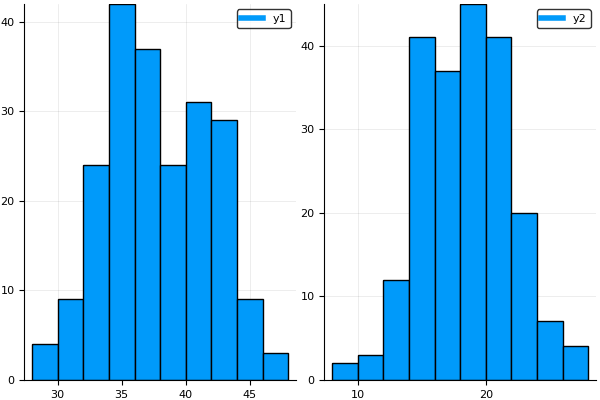

In [10]:
using Plots
pyplot()
Y = convert(Matrix{Float64}, SNP_29C_trait[:, 4:end])
histogram(Y, layout = 2)

## Pre-processing data for heritability analysis

### Inverse-Normal Transformation

In this example, we consider a Rank-Based Inverse Normal Blom Transformations to remedy non-Normal Trait Values.

In [11]:
using Rmath

c = 3/8 # continuity correction c = 3/8
N = size(Y)[1]

Yt = zeros(Matrix{Float64}(size(Y)[1],size(Y)[2]))

tic()
for i in 1:size(Y)[2]
    for j in 1:size(Y)[1]
        value = (tiedrank(Y[:,i]) - c)/(N - 2c + 1)
        qz = qnorm.(value)
        Yt[j, i] = qz[j]
    end
end
toc() 

elapsed time: 2.73965812 seconds


2.73965812


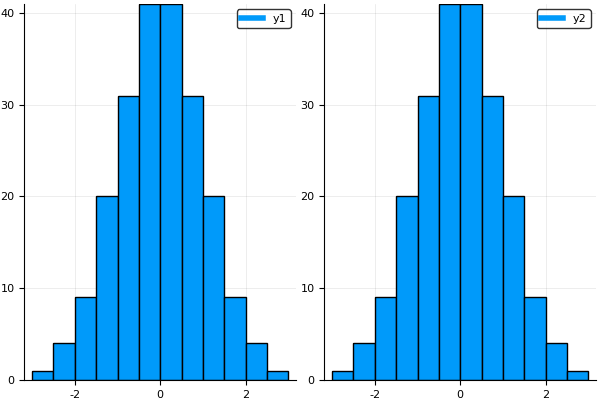

In [12]:
histogram(Yt, layout = 2 )

## Univariate Association Study

In [13]:
SNP_29C_genotypes = readcsv("genotypes29c.csv", Float64; header = false)

212×14 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  2.0  2.0  1.0  1.0
 ⋮                        ⋮                        ⋮             

## Linear Mixed Model

### LMM using Empirical Kinship matrix

In [14]:
using VarianceComponentModels
using Distributions

LMM_pval = zeros(14,2)
LMM_reg_coeff = zeros(14,2)

tic()
for i in 1:2
outcome = Y[:, i]
    for j in 1:14
locus = convert(Vector{Float64}, SNP_29C_genotypes[:, j])
X = [ones(length(locus)) locus sex]
locusdata = VarianceComponentVariate(outcome, X, (2ΦGRM, eye(length(outcome))))
locusmodel = VarianceComponentModel(locusdata)
@time logl, model_mle, Σse, Σcov, Bse, Bcov = fit_mle!(locusmodel, locusdata; algo = :FS)
pval = ccdf(Chisq(1), (model_mle.B[2] / Σse[2][1])^2) 
        LMM_pval[j, i] = pval[1]
        LMM_reg_coeff[j, i] = model_mle.B[2]
    end
end
toc() 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa


Use "VarianceComponentModel{T,M,BT,ΣT}(...) where {T,M,BT,ΣT}" instead.

Use "TwoVarCompModelRotate{T,BT}(...) where {T,BT}" instead.

Use "VarianceComponentVariate{T,M,YT,XT,VT}(...) where {T,M,YT,XT,VT}" instead.

Use "TwoVarCompVariateRotate{T,YT,XT}(...) where {T,YT,XT}" instead.


5.108632 seconds (3.37 M allocations: 158.562 MiB, 1.71% gc time)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  0.062877 seconds (15.63 k allocations: 2.314 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.052616 seconds (15.63 k allocations: 2.314 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.053443 seconds (15.63 k allocations: 2.314 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.048633 seconds (14.41 k allocations: 2.221 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

12.334143783

In [15]:
Empirical_Association_coeff = hcat(SNP_list, LMM_reg_coeff)

14×3 Array{Any,2}:
 "rs35121332"  1.38255  1.16125
 "rs59004768"  1.34699  1.02493
 "rs55799796"  1.20019  1.36688
 "rs3826883"   1.35883  1.35903
 "rs34804158"  1.23895  1.388  
 "rs10412915"  1.27958  1.5742 
 "rs11672206"  1.32415  1.37025
 "rs2116886"   1.21601  1.40509
 "rs71367132"  1.21601  1.40509
 "rs11667481"  1.32415  1.37025
 "rs1036231"   1.21601  1.40509
 "rs1036232"   1.21601  1.40509
 "rs11671837"  1.32415  1.37025
 "rs7253480"   1.32415  1.37025

In [16]:
Empirical_Association_pval = hcat(SNP_list, LMM_pval)

14×3 Array{Any,2}:
 "rs35121332"  0.00925361  0.0409742 
 "rs59004768"  0.0117049   0.0724062 
 "rs55799796"  0.0270361   0.0149611 
 "rs3826883"   0.010773    0.0150021 
 "rs34804158"  0.0220163   0.0133796 
 "rs10412915"  0.0165708   0.00434584
 "rs11672206"  0.0130983   0.0141421 
 "rs2116886"   0.0247249   0.012185  
 "rs71367132"  0.0247249   0.012185  
 "rs11667481"  0.0130983   0.0141421 
 "rs1036231"   0.0247249   0.012185  
 "rs1036232"   0.0247249   0.012185  
 "rs11671837"  0.0130983   0.0141421 
 "rs7253480"   0.0130983   0.0141421 

### LMM using Theoretical Kinship matrix

In [17]:
using Distributions

LMM_pval_ped = zeros(14,2)
LMM_reg_coeff_ped = zeros(14,2)

tic()
for i in 1:2
outcome = Y[:, i]
    for j in 1:14
locus = convert(Vector{Float64}, SNP_29C_genotypes[:, j])
X = [ones(length(locus)) locus sex]
locusdata = VarianceComponentVariate(outcome, X, (2ΦGRM_ped, eye(length(outcome))))
locusmodel = VarianceComponentModel(locusdata)
@time logl, model_mle, Σse, Σcov, Bse, Bcov = fit_mle!(locusmodel, locusdata; algo = :FS)
pval = ccdf(Chisq(1), (model_mle.B[2] / Σse[2][1])^2) 
        LMM_pval_ped[j, i] = pval[1]
        LMM_reg_coeff_ped[j, i] = model_mle.B[2]
    end
end
toc() 

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  0.121505 seconds (25.39 k allocations: 3.059 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.091465 seconds (21.73 k allocations: 2.780 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.090939 seconds (21.73 k allocations: 2.780 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

  0.059992 seconds (14.41 k allocations: 2.221 MiB)
This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

2.541952149

In [18]:
Theoretical_Association_coeff = hcat(SNP_list, LMM_reg_coeff_ped)

14×3 Array{Any,2}:
 "rs35121332"  1.61276  1.3627 
 "rs59004768"  1.57381  1.23957
 "rs55799796"  1.30871  1.57978
 "rs3826883"   1.48525  1.58873
 "rs34804158"  1.3463   1.60001
 "rs10412915"  1.35138  1.75613
 "rs11672206"  1.43203  1.59751
 "rs2116886"   1.3048   1.60845
 "rs71367132"  1.3048   1.60845
 "rs11667481"  1.43203  1.59751
 "rs1036231"   1.3048   1.60845
 "rs1036232"   1.3048   1.60845
 "rs11671837"  1.43203  1.59751
 "rs7253480"   1.43203  1.59751

In [19]:
Theoretical_Association_pval = hcat(SNP_list, LMM_pval_ped)

14×3 Array{Any,2}:
 "rs35121332"  0.00713796  0.0589558 
 "rs59004768"  0.01011     0.0917012 
 "rs55799796"  0.0491101   0.0215662 
 "rs3826883"   0.0213659   0.0221247 
 "rs34804158"  0.0416415   0.0196909 
 "rs10412915"  0.0396965   0.00862388
 "rs11672206"  0.0268263   0.0197403 
 "rs2116886"   0.0485874   0.0175315 
 "rs71367132"  0.0485874   0.0175315 
 "rs11667481"  0.0268263   0.0197403 
 "rs1036231"   0.0485874   0.0175315 
 "rs1036232"   0.0485874   0.0175315 
 "rs11671837"  0.0268263   0.0197403 
 "rs7253480"   0.0268263   0.0197403 

As expected, we find that all 14 SNP's are significantly associated with both Traits 1 and 2 when using either the empirical or theoretical kinship matrices. 

We now write the association coefficients and p-value estimates to .csv files on our own machine.

In [20]:
dfEmpirical_Association_pval = DataFrame(Empirical_Association_pval)
dfLMM_reg_coeff = DataFrame(Empirical_Association_coeff)
dfTheoretical_Association_pval = DataFrame(Theoretical_Association_pval)
dfLMM_reg_coeff_ped = DataFrame(Theoretical_Association_coeff)
writetable("LMM_pval_emp.csv", dfEmpirical_Association_pval, separator = ',', header = false)
writetable("LMM_reg_coeff_emp.csv", dfLMM_reg_coeff, separator = ',', header = false)
writetable("LMM_pval_ped.csv", dfTheoretical_Association_pval, separator = ',', header = false)
writetable("LMM_reg_coeff_ped.csv", dfLMM_reg_coeff_ped, separator = ',', header = false)